<a href="https://colab.research.google.com/github/magnusbrigido/ClassroomProject/blob/main/C%C3%B3pia_de_lab_3_iteracao_de_politica_truncada.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [132]:
# Instala os pacotes necessários:
# - gymnasium[toy-text]: inclui ambientes simples como FrozenLake, Taxi, etc.
# - imageio[ffmpeg]: permite salvar vídeos e GIFs (formato .mp4 ou .gif)
!pip install gymnasium[toy-text] imageio[ffmpeg]

In [133]:
# Importa as bibliotecas principais
import gymnasium as gym               # Biblioteca de simulações de ambientes para RL
import imageio                        # Usada para salvar a sequência de frames como GIF
from IPython.display import Image     # Para exibir a imagem (GIF) diretamente no notebook
import numpy as np                    # Importa o pacote NumPy, amplamente utilizado para manipulação de arrays e operações numéricas vetoriais
from typing import Dict, Tuple, List  # Importa ferramentas de tipagem estática do Python

In [134]:
def avaliar_politica_truncada(
    P: Dict[int, Dict[int, List[Tuple[float, int, float, bool]]]],
    politica: Dict[int, int],
    n_estados: int,
    gamma: float = 0.9,
    j_truncado: int = 5,
    V: np.ndarray | None = None
) -> np.ndarray:
    """
    Executa a avaliação truncada de uma política fixa (limitada a j_truncado iterações).

    Esta versão não modifica o vetor V original (não é in-place) e assume V(s') = 0 para estados terminais s'.

    Parâmetros:
    - P: dicionário de transições do ambiente (env.P), com estrutura:
         Dict[estado, Dict[ação, List[Tuple[probabilidade, próximo_estado, recompensa, terminal]]]]
    - politica: dicionário que mapeia cada estado (int) para uma ação (int)
    - n_estados: número total de estados
    - gamma: fator de desconto (0 < gamma <= 1)
    - j_truncado: número máximo de iterações de avaliação por rodada
    - V: vetor de valores de estado (opcional). Se None, inicializa com zeros.

    Retorna:
    - V: vetor de valores de estado V (numpy array) para todos os estados
    """
    if V is None:
        V = np.zeros(n_estados)

    ############################################################################################################
    # AVALIAÇÃO DA POLÍTICA ATUAL
    ############################################################################################################
    # Código aqui
    for _ in range(j_truncado):
        novo_V = np.zeros(n_estados)
        for s in range(n_estados):
            a = politica[s]
            novo_V[s] = sum(
                p * (r + gamma * V[s_prime] * (not done))
                for (p, s_prime, r, done) in P[s][a]
            )
        V = novo_V.copy()
    ############################################################################################################

    return V

In [135]:
def melhorar_politica(
    P: Dict[int, Dict[int, List[Tuple[float, int, float, bool]]]],
    politica_atual: Dict[int, int],
    V: np.ndarray,
    n_estados: int,
    n_acoes: int,
    gamma: float = 0.9
) -> Tuple[np.ndarray, Dict[int, int], bool]:
    Q = np.zeros((n_estados, n_acoes))
    nova_politica: Dict[int, int] = {}
    politica_estavel = True

    ############################################################################################################
    # MELHORIA DA POLÍTICA
    ############################################################################################################
    # Código aqui
    for s in range(n_estados):
        for a in range(n_acoes):
            Q[s][a] = sum(
                p * (r + gamma * V[s_prime] * (not done))
                for (p, s_prime, r, done) in P[s][a]
            )

        melhor_acao = int(np.argmax(Q[s]))
        nova_politica[s] = melhor_acao

        if melhor_acao != politica_atual[s]:
            politica_estavel = False
    ############################################################################################################

    return Q, nova_politica, politica_estavel

In [136]:
def iteracao_de_politica_truncada(
    env: gym.Env,
    gamma: float = 0.9,
    j_truncado: int = 5,
    max_iteracoes: int = 1000
) -> Tuple[np.ndarray, np.ndarray, Dict[int, int]]:
    """
    Executa o algoritmo de Iteração de Política com avaliação truncada para ambientes Gymnasium (baseados em env.P).

    Parâmetros:
    - env: ambiente compatível com Gymnasium que possui o atributo env.P
    - gamma: fator de desconto (0 < gamma <= 1)
    - j_truncado: número de iterações da avaliação de política por rodada (truncagem)
    - max_iteracoes: número máximo de iterações de melhoria de política

    Retorna:
    - V: vetor de valores de estado V(s)
    - Q: matriz de valores de ação Q(s,a)
    - politica: dicionário estado → ação (int → int)
    """

    env = env.unwrapped         # Garante acesso direto ao modelo

    n_estados = env.observation_space.n
    n_acoes = env.action_space.n
    P = env.P

    # Inicializa a política com ações aleatórias
    politica: Dict[int, int] = {s: np.random.choice(n_acoes) for s in range(n_estados)}
    V = np.zeros(n_estados)

    for k in range(max_iteracoes):
        # Etapa 1: Avaliação truncada da política atual
        V = avaliar_politica_truncada(P, politica, n_estados, gamma=gamma, j_truncado=j_truncado, V=V)

        # Etapa 2: Melhoria da política
        Q, nova_politica, politica_estavel = melhorar_politica(P, politica, V, n_estados, n_acoes, gamma=gamma)

        # Se a política não mudou, convergimos
        if politica_estavel:
            break

        # Atualiza política
        politica = nova_politica

    return V, Q, politica, k

In [137]:
def visualizar_politica(politica: Dict[int, int], shape: Tuple[int, int]) -> None:
    """Exibe a política em uma grade com setas para cada ação."""
    direcoes = {0: '←', 1: '↓', 2: '→', 3: '↑'}
    grid = np.array([direcoes[politica[s]] if s in politica else ' ' for s in range(shape[0]*shape[1])])
    print("\nPolítica ótima:")
    print(grid.reshape(shape))

In [138]:
# Cria o ambiente FrozenLake
# is_slippery=False: torna o ambiente determinístico (sem escorregões)
# render_mode="rgb_array": retorna imagens do ambiente como arrays de pixels
# map_name='8x8':  tamanho do mapa (pode ser '4x4' ou '8x8')
map_name = '4x4'
render_mode="rgb_array"
is_slippery=False
env = gym.make("FrozenLake-v1", map_name=map_name, render_mode=render_mode, is_slippery=is_slippery)
env = env.unwrapped  # isso é ESSENCIAL para acessar env.P
################################################################################
# Estrutura de env.P
################################################################################
# env.P: Dict[int, Dict[int, List[Tuple[float, int, float, bool]]]]
# env.P = {
#     estado_0: {
#         acao_0: [(p, s', r, done), ...],
#         acao_1: [(p, s', r, done), ...],
#         ...
#     },
#     estado_1: {
#         acao_0: [(p, s', r, done), ...],
#         ...
#     },
#     ...
# }
# (p, s', r, done) = (probabilidade, proximo_estado, recompensa, finalizado)
# probabilidade = p(s',r|s,a)
################################################################################

In [139]:
# Obter a política ótima
_, _, politica_otima, k = iteracao_de_politica_truncada(env)

In [140]:
# Visualizar a poltíca ótima
if map_name == '4x4':
  shape = (4, 4)
else:
  shape=(8, 8)
visualizar_politica(politica_otima, shape=shape)


Política ótima:
[['↓' '→' '↓' '←']
 ['↓' '←' '↓' '←']
 ['→' '↓' '↓' '←']
 ['←' '→' '→' '←']]


In [141]:
env = gym.make("FrozenLake-v1", map_name=map_name, render_mode=render_mode, is_slippery=is_slippery)    # Cria o ambiente FrozenLake
frames = []                                                                                             # Lista que armazenará todos os frames (imagens) do episódio
n_episodios = 5                                                                                         # Número de episódios
for ep in range(n_episodios):
  observation, info = env.reset()                                                                       # Reinicia o ambiente e obtém o primeiro estado (observation)
  for _ in range(100):                                                                                  # Executa um episódio de até 100 passos
      action = politica_otima[observation]                                                              # Seleciona a ação da política ótima
      observation, reward, terminated, truncated, info = env.step(action)                               # Aplica a ação no ambiente
      frames.append(env.render())                                                                       # Captura a imagem do ambiente após a ação
      if terminated or truncated:                                                                       # Verifica se o episódio acabou (chegou no objetivo ou caiu no buraco)
          break
env.close()                                                                                             # Encerra o ambiente corretamente

In [142]:
# Salva os frames coletados como um arquivo GIF animado
gif_path = "frozenlake.gif"
imageio.mimsave(gif_path, frames, format="GIF", fps=2)

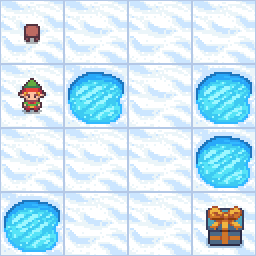

In [143]:
# Exibe o GIF diretamente no notebook
Image(filename=gif_path)

# Tarefa:

1. Modifique o código do algoritmo de iteração de política truncada para também retornar a iteração k em que a condição de convergência foi satisfeita.
2. Gere um gráfico de dispersão considerando (x,y) = (iteração em que a condição de convergência foi satisfeita, j_truncado).

Utilize os mapas '4x4' e '8x8' nos experimentos e comente sobre os resultados obtidos nos itens 1 e 2.

Entregar o PDF do notebook no colab (código + relatório em markdown)

#### Após alterar o código tem-se a quantidade de iterações necessárias

In [144]:
print('Convergiu em ', k, ' iterações')

Convergiu em  5  iterações


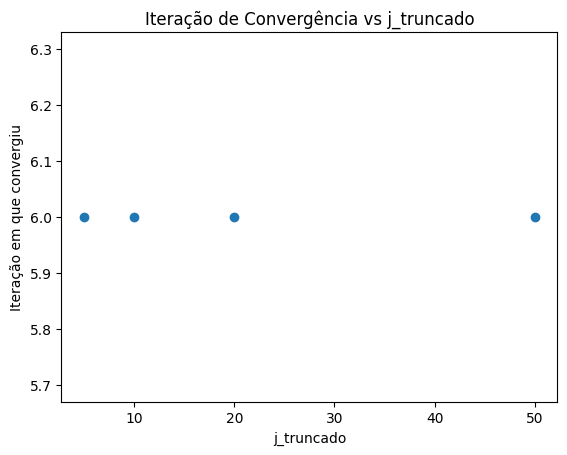

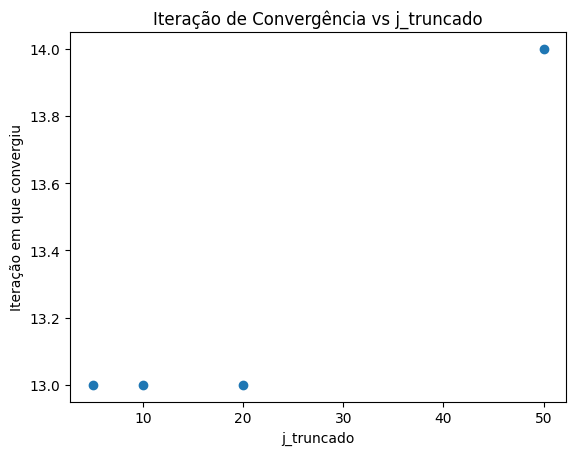

In [145]:
import matplotlib.pyplot as plt

def gerar_grafico_convergencia(env: gym.Env, j_truncado_vals: List[int], max_iteracoes: int = 1000):
    iteracoes_convergencia = []

    for j_truncado in j_truncado_vals:
        _, _, _, k = iteracao_de_politica_truncada(env, gamma=0.9, j_truncado=j_truncado, max_iteracoes=max_iteracoes)
        iteracoes_convergencia.append(k)

    # Gerando o gráfico de dispersão
    plt.scatter(j_truncado_vals, iteracoes_convergencia)
    plt.xlabel('j_truncado')
    plt.ylabel('Iteração em que convergiu')
    plt.title('Iteração de Convergência vs j_truncado')
    plt.show()

# Experimentando com os mapas '4x4' e '8x8'
mapas = ['4x4', '8x8']
j_truncado_vals = [5, 10, 20, 50]

for map_name in mapas:
    env = gym.make("FrozenLake-v1", map_name=map_name, render_mode="rgb_array", is_slippery=False)
    gerar_grafico_convergencia(env, j_truncado_vals)


No mapa 4x4 e 8x8 a quantidade para convergência varia bastante a cada execução. Demonstrando que os pontos de cada gráfico dependem da execução, que produz uma quantidade melhor ou não. O que manteve igual para toda execução foi que para um mapa maior é necessário mais iterações, isto é devido ao aumento de complexidade por possuir uma quantidade de estados bem maior no mapa 8x8 em relação ao mapa 4x4